# Import Packages

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
import graphviz

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("CUDA available:", tf.test.is_built_with_cuda())
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
CUDA available: True
GPUs available: 1


# 1. Load Data

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [5]:
train_images.shape, test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

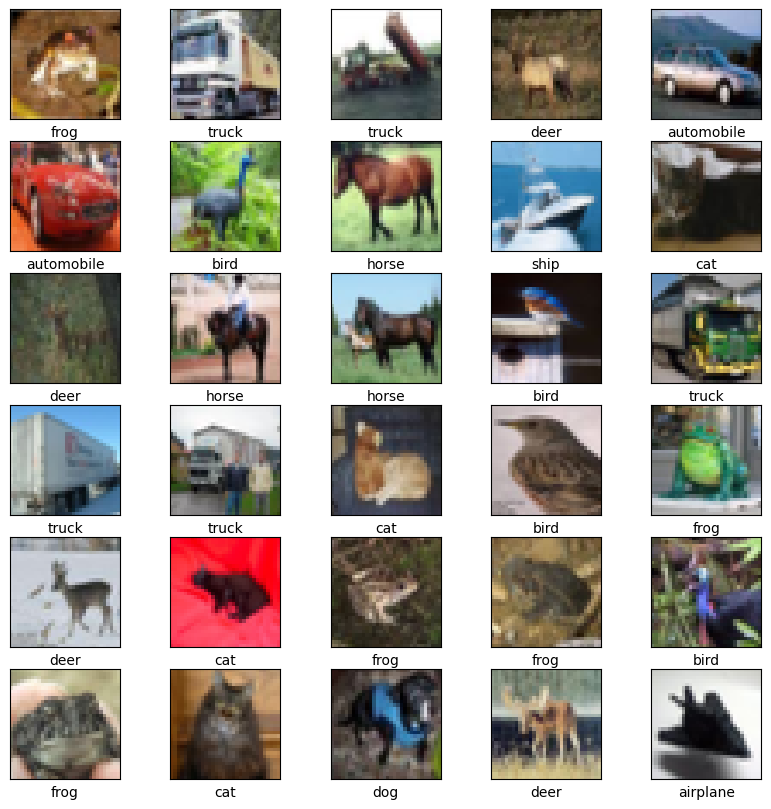

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

f1score = tfa.metrics.F1Score(num_classes=10, average='weighted')

In [10]:
def show_epoch(history):
    metrics_list = ['loss', 'accuracy']
    num_metrics = len(metrics_list)
    num_cols = 2
    num_rows = (num_metrics + 1) // num_cols

    plt.figure(figsize=(15, num_rows * 5))

    for i, metric in enumerate(metrics_list):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    # Set tick labels
    ax.xaxis.set_ticklabels(class_names, rotation=90, ha="right", fontsize=10)
    ax.yaxis.set_ticklabels(class_names, rotation=0, fontsize=10)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def display_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    metrics = { 'Model': model_name,
               'Accuracy': accuracy,
               'F1 score': f1,
               'Precision': precision,
               'Recall': recall}

    return metrics

# 2. Split the Data and Rescaling

## 2.1 Split Data

In [12]:
validation_images, test_images, validation_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.6, random_state=42)

print(f"Train Images: {train_images.shape}")
print(f"Train Labels: {train_labels.shape}")

print(f"Validation Images: {validation_images.shape}")
print(f"Validation Labels: {validation_labels.shape}")

print(f"Test Images: {test_images.shape}")
print(f"Test Labels: {test_labels.shape}")

Train Images: (50000, 32, 32, 3)
Train Labels: (50000, 1)
Validation Images: (4000, 32, 32, 3)
Validation Labels: (4000, 1)
Test Images: (6000, 32, 32, 3)
Test Labels: (6000, 1)


## 2.2 Rescaling the Data

In [13]:
train_images = train_images / 255.0
validation_images = validation_images / 255.0
test_images = test_images / 255.0

# 3. Train Models

## 3.1 Simple CNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

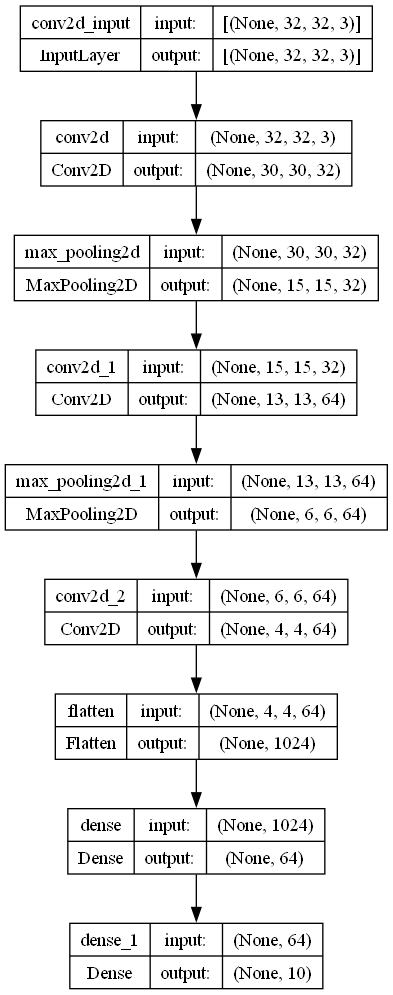

In [14]:
cnn_simple = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

cnn_simple.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

cnn_simple.summary()

cnn_simple_history = cnn_simple.fit(
    train_images, train_labels,
    epochs = 20,
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stopping]
)
tf.keras.utils.plot_model(cnn_simple, show_shapes=True)

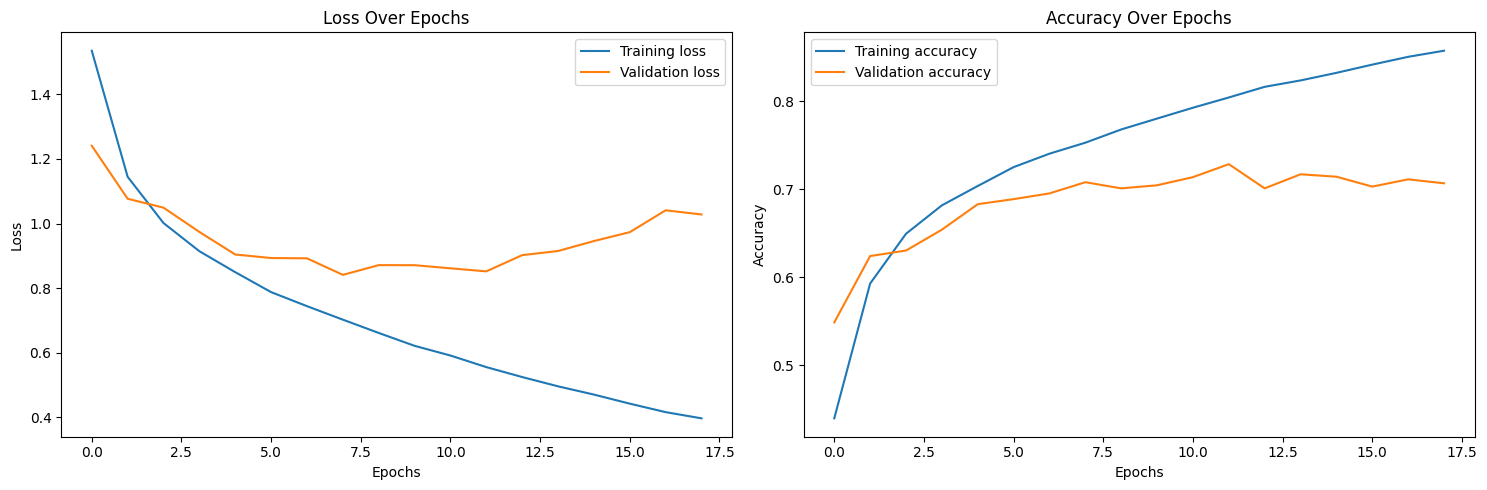

125/125 [==============================] - 0s 2ms/step


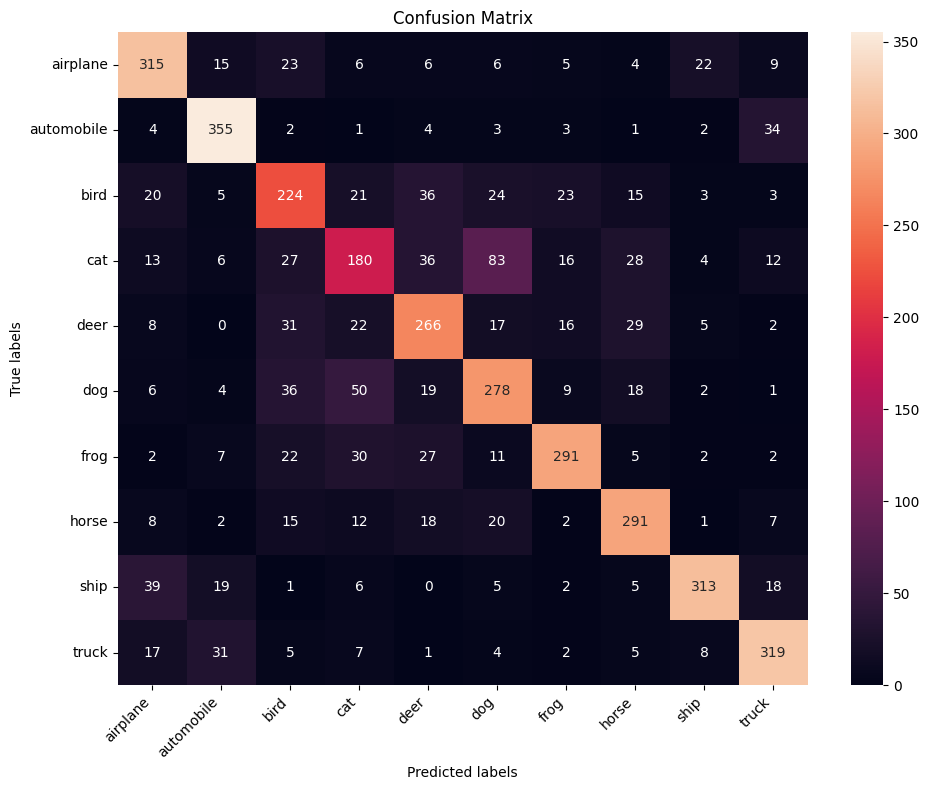

{'Model': 'Simple CNN', 'Accuracy': 0.708, 'F1 score': 0.706529469763748, 'Precision': 0.7075406254470752, 'Recall': 0.708}


In [15]:
show_epoch(cnn_simple_history)

# Predict the classes for the validation set
y_pred_cnn_simple = cnn_simple.predict(validation_images)
y_pred_classes_cnn_simple = np.argmax(y_pred_cnn_simple, axis=1)
y_true_classes_cnn_simple = validation_labels.flatten()

cnn_simple_cm = display_confusion_matrix(y_true_classes_cnn_simple, y_pred_classes_cnn_simple)

cnn_simple_metrics = display_metrics(y_true_classes_cnn_simple, y_pred_classes_cnn_simple, "Simple CNN")
print(cnn_simple_metrics)

## 3.2 VGG-16

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_59 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                 

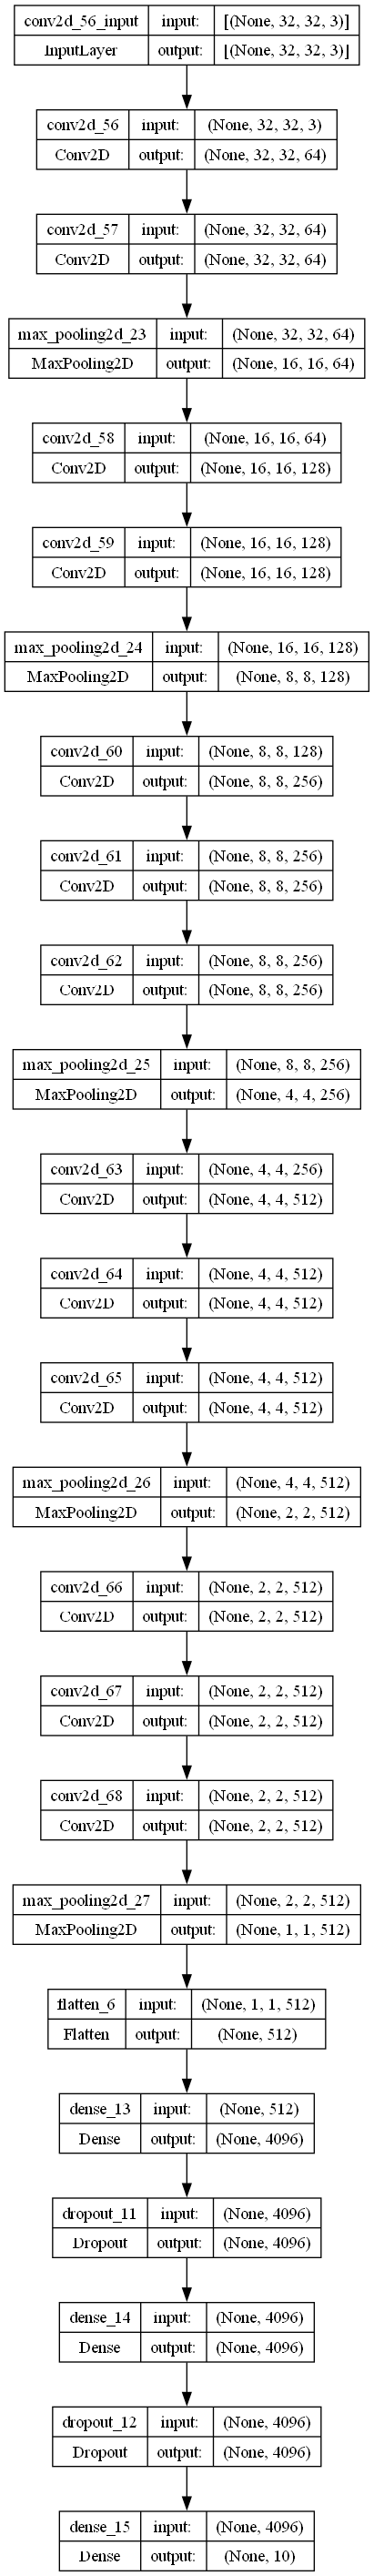

In [24]:
# 定义 VGG-16 模型结构
vgg16_model = models.Sequential([
    # 第一个卷积块
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    # 第二个卷积块
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    # 第三个卷积块
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    # 第四个卷积块
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    # 第五个卷积块
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    # 全连接层
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10)  # CIFAR-10 有 10 个类别
])

# 编译模型
vgg16_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

# 打印模型结构
vgg16_model.summary()

# 设置 EarlyStopping 和 ReduceLROnPlateau 回调
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 训练模型
vgg16_history = vgg16_model.fit(
    train_images, train_labels,
    epochs=20,
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stopping_callback, reduce_lr_callback]
)

# 可选：绘制模型结构图
tf.keras.utils.plot_model(vgg16_model, show_shapes=True)

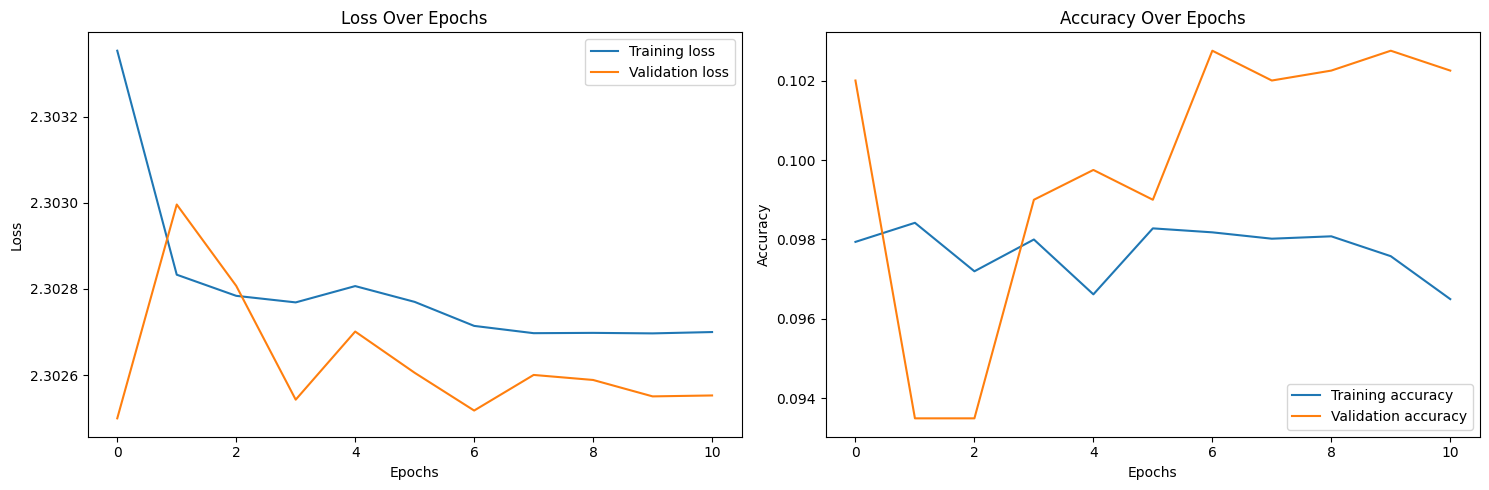

125/125 [==============================] - 1s 5ms/step


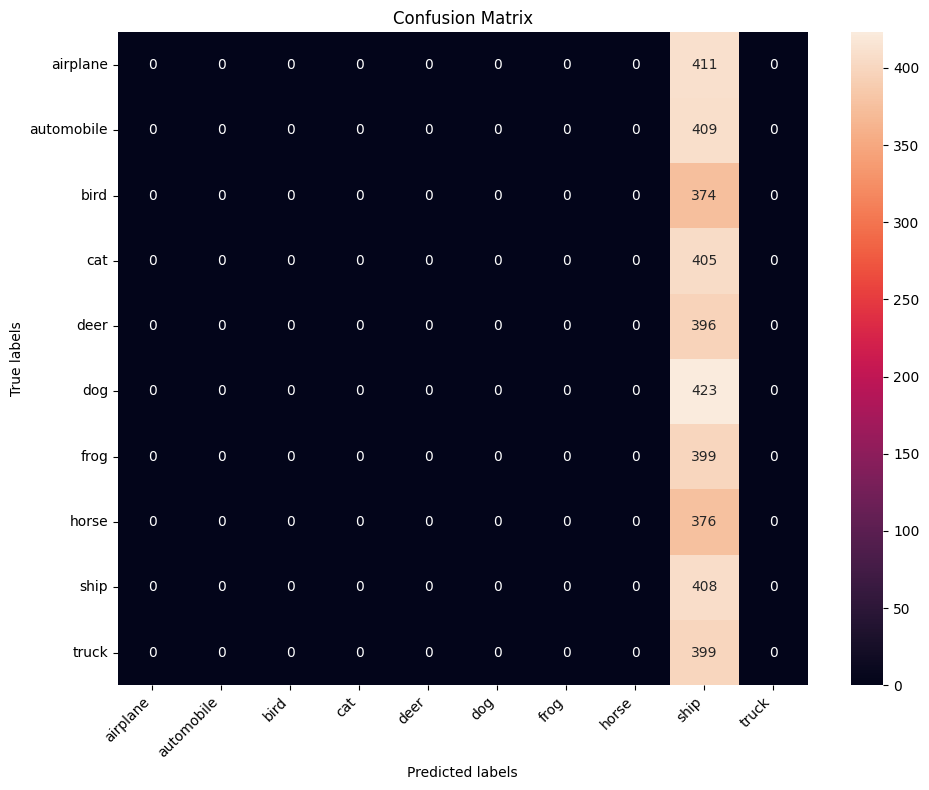

{'Model': 'VGG-16', 'Accuracy': 0.102, 'F1 score': 0.018882032667876587, 'Precision': 0.010404, 'Recall': 0.102}


C:\anaconda\envs\tf_gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# 显示训练过程
show_epoch(vgg16_history)

# 使用 VGG-16 模型预测验证集的类别
y_pred_vgg16 = vgg16_model.predict(validation_images)
y_pred_classes_vgg16 = np.argmax(y_pred_vgg16, axis=1)
y_true_classes_vgg16 = validation_labels.flatten()

# 绘制混淆矩阵
vgg16_cm = display_confusion_matrix(y_true_classes_vgg16, y_pred_classes_vgg16)

# 计算和显示评估指标
vgg16_metrics = display_metrics(y_true_classes_vgg16, y_pred_classes_vgg16, "VGG-16")
print(vgg16_metrics)

## 3.3 RestNet-18

In [26]:
@tf.keras.utils.register_keras_serializable()
class ResNetBlock(tf.keras.Model):
    def __init__(self, num_filters, filter_size=(3, 3), downsample=False, **kwargs):
        super(ResNetBlock, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.downsample_flag = downsample

        # First convolutional layer with optional downsampling
        self.conv_layer1 = tf.keras.layers.Conv2D(num_filters, filter_size, padding='same')
        self.batch_norm1 = tf.keras.layers.BatchNormalization()

        # Second convolutional layer
        self.conv_layer2 = tf.keras.layers.Conv2D(num_filters, filter_size, padding='same')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()

        self.residual_shortcut = lambda x: x
        if downsample:
            self.conv_layer1 = tf.keras.layers.Conv2D(num_filters, filter_size, padding='same', strides=(2, 2))
            self.residual_shortcut = tf.keras.Sequential([
                tf.keras.layers.Conv2D(num_filters, (1, 1), strides=(2, 2)),
                tf.keras.layers.BatchNormalization()
            ])

        # Activation and addition layers
        self.addition = tf.keras.layers.Add()
        self.activation = tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv_layer1(inputs)
        x = self.batch_norm1(x)
        x = self.activation(x)

        # Second convolutional pass
        x = self.conv_layer2(x)
        x = self.batch_norm2(x)

        shortcut = self.residual_shortcut(inputs)
        x = self.addition([x, shortcut])
        x = self.activation(x)

        return x

    def get_config(self):
        # Saving the configuration for serialization
        base_config = super(ResNetBlock, self).get_config()
        base_config.update({
            'num_filters': self.num_filters,
            'filter_size': self.filter_size,
            'downsample': self.downsample_flag
        })
        return base_config


In [27]:
restnet18 = models.Sequential([
    layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    ResNetBlock(64),
    ResNetBlock(64),
    ResNetBlock(128, downsample=True),
    ResNetBlock(128),
    ResNetBlock(256, downsample=True),
    ResNetBlock(256),
    ResNetBlock(512, downsample=True),
    ResNetBlock(512),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10)
])

restnet18.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

restnet18.summary()

restnet18_history = restnet18.fit(
    train_images, train_labels,
    epochs=20,
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stopping]
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 res_net_block (ResNetBlock)  (None, 8, 8, 64)         74368     
                                                                 
 res_net_block_1 (ResNetBloc  (None, 8, 8, 64)        

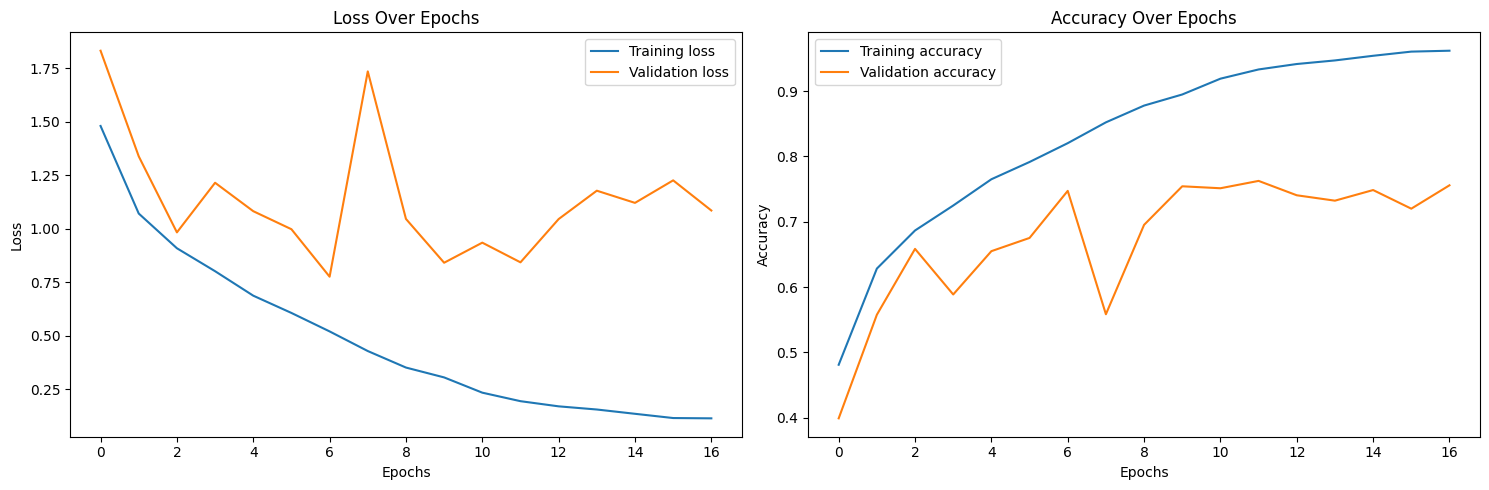

In [28]:
show_epoch(restnet18_history)

In [29]:
# Save the model
restnet18.save('model_restnet18.keras')

In [30]:
# Load the model
restnet18 = tf.keras.models.load_model('model_restnet18.keras', custom_objects={'ResNetBlock': ResNetBlock})

125/125 [==============================] - 1s 7ms/step


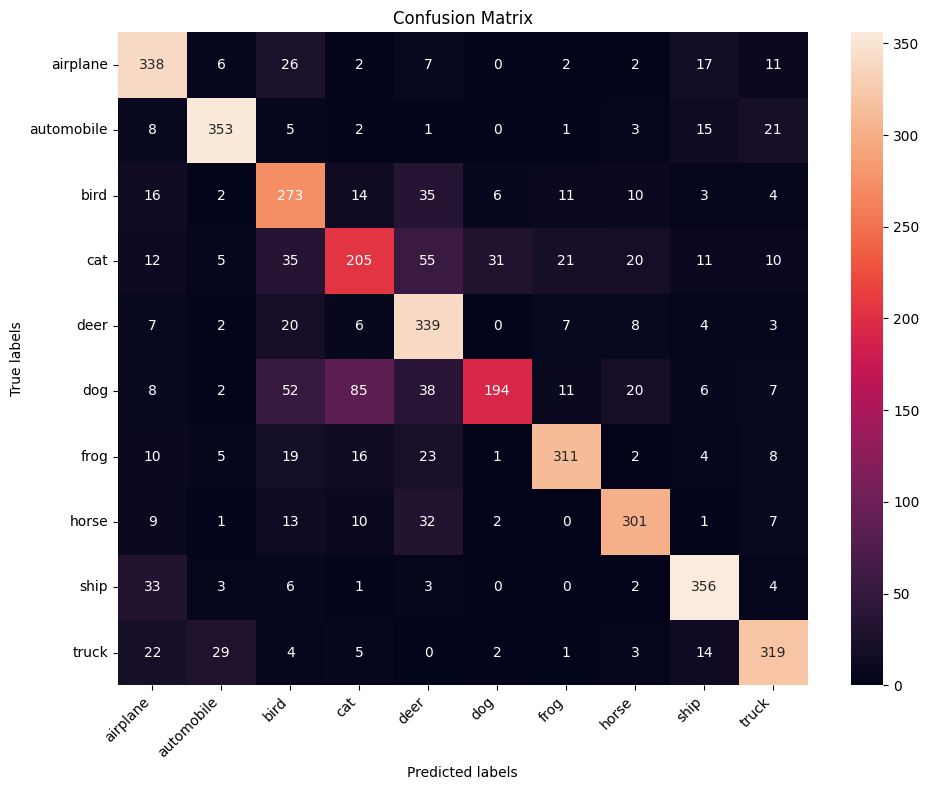

{'Model': 'ResNet-18', 'Accuracy': 0.74725, 'F1 score': 0.7431283967858485, 'Precision': 0.7559784284305953, 'Recall': 0.74725}


In [31]:
y_pred_resnet18 = restnet18.predict(validation_images)
y_pred_classes_resnet18 = np.argmax(y_pred_resnet18, axis=1)
y_true_classes_resnet18 = validation_labels.flatten()

resnet18_cm = display_confusion_matrix(y_true_classes_resnet18, y_pred_classes_resnet18)

resnet18_metrics = display_metrics(y_true_classes_resnet18, y_pred_classes_resnet18, "ResNet-18")
print(resnet18_metrics)

## 3.4 AlexNet

In [32]:
@tf.keras.utils.register_keras_serializable()
class AlexNetBlock(tf.keras.Model):
    def __init__(self, num_filters, filter_size=(3, 3), pool_size=(2, 2), **kwargs):
        super(AlexNetBlock, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.pool_size = pool_size

        # Convolutional layer
        self.conv_layer = tf.keras.layers.Conv2D(num_filters, filter_size, padding='same')
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

        # Max pooling layer
        self.max_pool = tf.keras.layers.MaxPooling2D(pool_size)

    def call(self, inputs):
        x = self.conv_layer(inputs)
        x = self.batch_norm(x)
        x = self.activation(x)
        x = self.max_pool(x)

        return x

    def get_config(self):
        # Saving the configuration for serialization
        base_config = super(AlexNetBlock, self).get_config()
        base_config.update({
            'num_filters': self.num_filters,
            'filter_size': self.filter_size,
            'pool_size': self.pool_size
        })
        return base_config

In [33]:
alexnet = models.Sequential([
    layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu', input_shape=(32, 32, 3), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10)
])

alexnet.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

alexnet.summary()

alexnet_history = alexnet.fit(
    train_images, train_labels,
    epochs=20,
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stopping]
)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_114 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_39 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_115 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_40 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                     

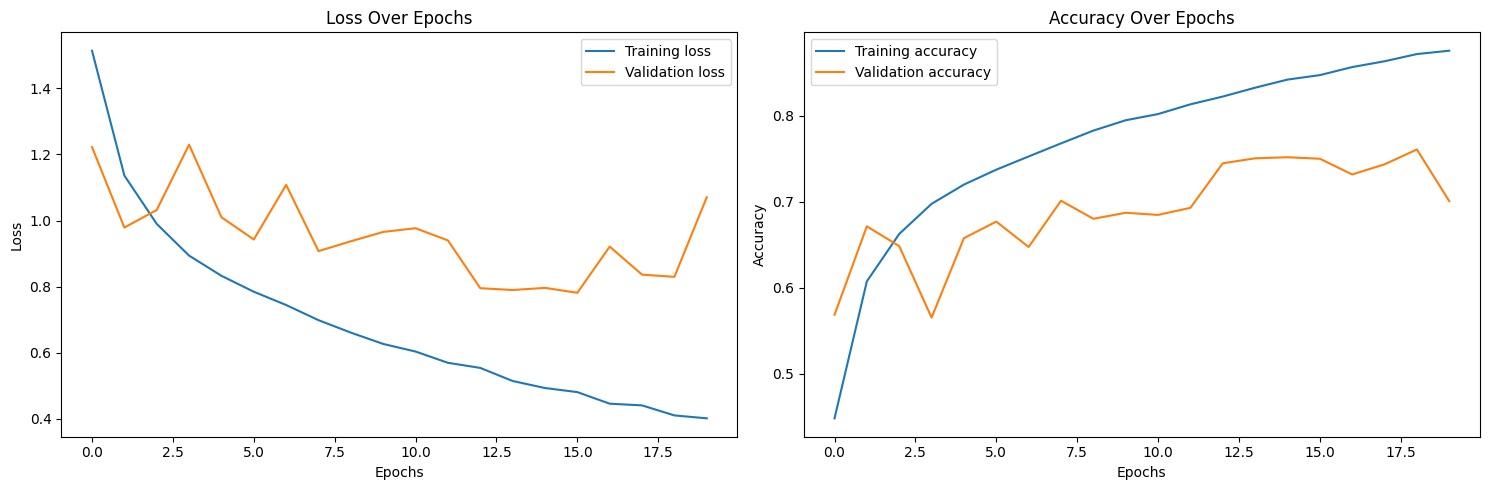

In [34]:
show_epoch(alexnet_history)

In [35]:
alexnet.save('model_alexnet.keras')

In [36]:
alexnet = tf.keras.models.load_model('model_alexnet.keras', custom_objects={'AlexNetBlock': AlexNetBlock})

125/125 [==============================] - 1s 5ms/step


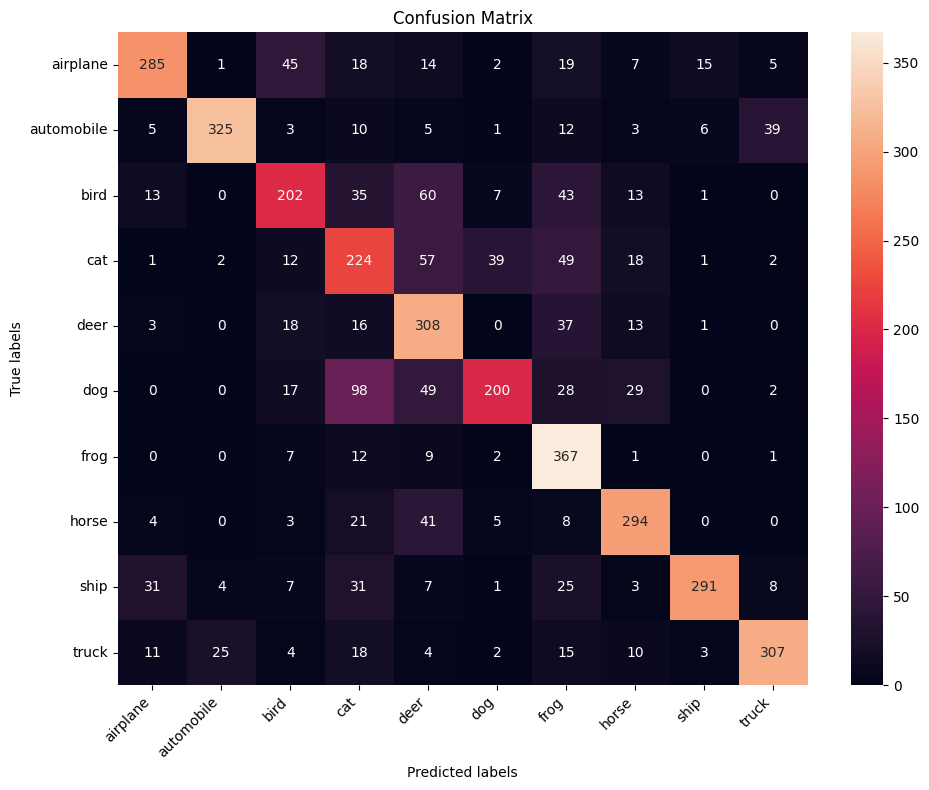

{'Model': 'AlexNet', 'Accuracy': 0.70075, 'F1 score': 0.7024818061253386, 'Precision': 0.7279510153562803, 'Recall': 0.70075}


In [37]:
y_pred_alexnet = alexnet.predict(validation_images)
y_pred_classes_alexnet = np.argmax(y_pred_alexnet, axis=1)
y_true_classes_alexnet = validation_labels.flatten()

alexnet_cm = display_confusion_matrix(y_true_classes_alexnet, y_pred_classes_alexnet)

alexnet_metrics = display_metrics(y_true_classes_alexnet, y_pred_classes_alexnet, "AlexNet")
print(alexnet_metrics)

# 4. Compare Models

        Model  Accuracy  F1 score  Precision   Recall
0  Simple CNN   0.70800  0.706529   0.707541  0.70800
1      VGG-16   0.10200  0.018882   0.010404  0.10200
2   ResNet-18   0.74725  0.743128   0.755978  0.74725
3     AlexNet   0.70075  0.702482   0.727951  0.70075


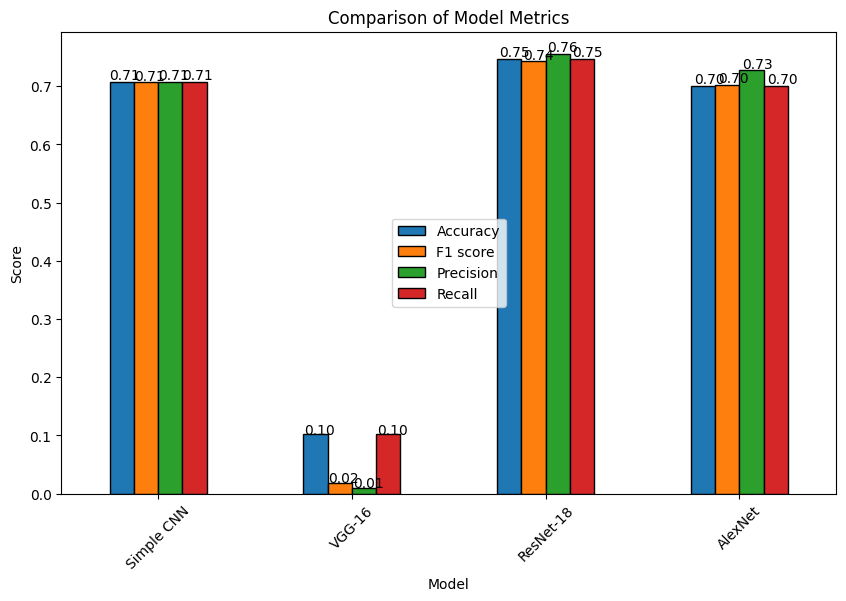

In [38]:
# Collect metrics from different models
metrics_list = [cnn_simple_metrics, vgg16_metrics, resnet18_metrics, alexnet_metrics]
df_metrics = pd.DataFrame(metrics_list)
print(df_metrics)

# Plot the bar chart
ax = df_metrics.set_index('Model').plot(kind='bar', figsize=(10, 6), edgecolor='black')
plt.title('Comparison of Model Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()